In [1]:
from math import log2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.tensorboard import SummaryWriter  # print to tensorboard
from torch.utils.data import DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import re
import argparse
import numpy as np


from src.models.utils.create_batch import EarthDataTrain
from src.models.model.model import Generator, Discriminator, init_weights
from src.models.loss.wasserstein import gradient_penalty


In [6]:
# for local compute
root_dir = Path.cwd().parent.parent  # set the root directory as a Pathlib path
print(root_dir)

path_prev_checkpoint = root_dir / "models/interim/checkpoints/2021_07_16_203548/train_20.pt" 

path_processed_data = root_dir / "data/processed"
path_input_folder = path_processed_data / "input"
path_truth_folder = path_processed_data / "truth"

/home/tim/Documents/earth-mantle-surrogate


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [9]:
gen = Generator(
    in_chan=4,
    out_chan=4,
    scale_factor=8,
    chan_base=64,
    chan_min=64,
    chan_max=128,
    cat_noise=True,
).to(device)

In [10]:
checkpoint = torch.load(path_prev_checkpoint)
# epoch_start = checkpoint['epoch']+1
gen.load_state_dict(checkpoint['gen'])
# critic.load_state_dict(checkpoint['critic'])
# opt_gen.load_state_dict(checkpoint['opt_gen'])
# opt_critic.load_state_dict(checkpoint['opt_critic'])

<All keys matched successfully>

In [11]:
earth_dataset = EarthDataTrain(path_input_folder, path_truth_folder, random_roll=False)

In [12]:
loader = DataLoader(
    earth_dataset,
    batch_size=1,
    shuffle=False,
)

In [13]:
for i, data in enumerate(loader):
    x_truth = data["truth"].to(device)
    x_up = data["upsampled"].to(device)
    x_input = data["input"].to(device)

In [14]:
x_input.shape

torch.Size([1, 4, 30, 20, 10])

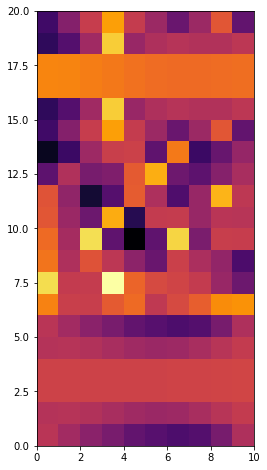

In [15]:
color_scheme='inferno'
fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.pcolormesh(x_input[0,0,0,:,:].cpu(), cmap=color_scheme)
ax.set_aspect(1)

In [20]:
with torch.no_grad():
    gen.eval()
    x_fake = gen(x_input)

In [21]:
x_fake.shape

torch.Size([1, 4, 198, 118, 38])

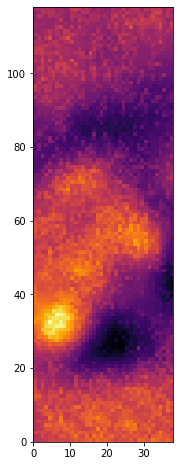

In [22]:
color_scheme='inferno'
fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.pcolormesh(x_fake[0,0,90,:,:].cpu(), cmap=color_scheme)
ax.set_aspect(1)

In [23]:
def pad_data(x, pad_top_bot=0, pad_sides=0):
    "pad top/bot or sides of tensor"
    if pad_sides > 0:
        x = torch.cat((x[:,:,:,:,-pad_sides:], x, x[:,:,:,:,:pad_sides]), axis=-1)

    if pad_top_bot > 0:
        x = torch.cat((torch.flip(x, [3])[:,:,:,-pad_top_bot:,:], # mirror array and select top rows
                         x, 
                         torch.flip(x, [3])[:,:,:,:pad_top_bot,:]), # mirror array and select bottom rows
                      axis=-2) # append along longitudinal (left-right) axis   
    return x

def crop_data(x, crop_height=1, crop_width=1,):
    "symetrically crop tensor"
    w = crop_width
    h = crop_height

    if crop_width == 0 and crop_height == 0:
        return x
    elif crop_width == 0:
        return x[:,:,:,h:-h,:]
    elif crop_height == 0:
        return x[:,:,:,:,w:-w]
    else:
        return x[:,:,:,h:-h,w:-w]

torch.Size([1, 4, 198, 14, 27])


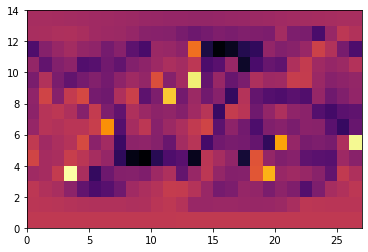

In [24]:
input_data = torch.tensor(np.load(path_input_folder / 'x_001.npy'))
print(input_data.shape)
plt.pcolormesh(input_data[0,0,90,:,:], cmap='inferno')

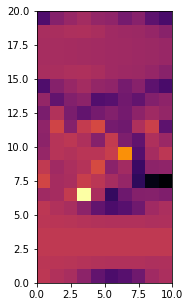

In [25]:
input_data = input_data[:,:,:,:,:10] # select first N points for width
input_data = pad_data(input_data, pad_top_bot=3, pad_sides=0) # hardcoded -- could make flexible in future
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.pcolormesh(input_data[0,0,90,:,:], cmap='inferno')
ax.set_aspect(1)

In [94]:
def gen_output_slice_for_concatenate(x_input, gen, roll_increment=0, width=32):
    """
    Args:
        x_input (tensor): Input (downsampled) sample.
        gen (pytorch model): Loaded pytorch model
        roll_increment (int): Amount to roll the input by. Standard x_input has width of 27
    """
    x_input = torch.roll(x_input, roll_increment, 4) # roll if used
    x_input = x_input[:,:,:,:,:10] # select first 10 points for width
    x_input = pad_data(x_input, pad_top_bot=3, pad_sides=0) # pad top/bottom

    with torch.no_grad():
        gen.eval()
        x_fake = gen(x_input)
        
        # x_fake shape: (1, 4, 198, 118, 38)
        return x_fake[:,:,:,:,3:width+3].detach().cpu()


torch.Size([1, 4, 198, 118, 32])


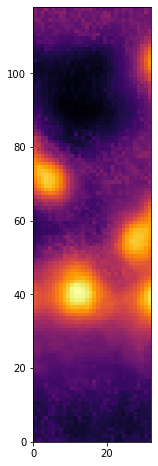

In [95]:
input_data = torch.tensor(np.load(path_input_folder / 'x_001.npy'))
# input to the generator needs 30 radial layers in order to get to a final radial output of 198
index_keep = np.round(np.arange(0,input_data.shape[2], input_data.shape[2]/30.0)).astype(int)
input_data = input_data[:,:,index_keep,:,:]

x_fake1=gen_output_slice_for_concatenate(input_data.to(device), gen, roll_increment=0, width=32)
print(x_fake1.shape)
color_scheme='inferno'
fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.pcolormesh(x_fake[0,0,90,:,:].cpu(), cmap=color_scheme)
ax.set_aspect(1)

In [108]:
x[0,0,90,:,:].max()

tensor(0.6411)

In [110]:
x[0,0,90,:,:].min()

tensor(0.5291)

In [119]:
for roll_n in range(0, 108, 4):
    print(roll_n)

0
4
8
12
16
20
24
28
32
36
40
44
48
52
56
60
64
68
72
76
80
84
88
92
96
100
104


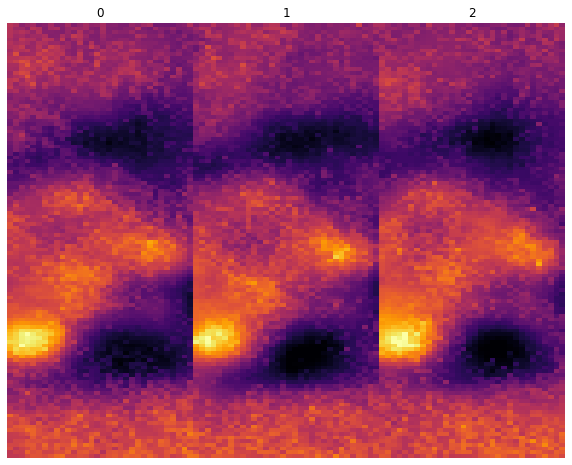

In [120]:
fake_list = []
title_list = []
for i, roll_n in enumerate(range(0, 12, 4)):
    fake=gen_output_slice_for_concatenate(input_data.to(device), gen, roll_increment=0, width=32)
    fake_list.append(fake)
    title_list.append(i)
    
    
x_fake1=gen_output_slice_for_concatenate(input_data.to(device), gen, roll_increment=0, width=32)
# print(x_fake1.shape)
# x_fake2=gen_output_slice_for_concatenate(input_data.to(device), gen, roll_increment=4, width=32)
# print(x_fake2.shape)
# x_fake3=gen_output_slice_for_concatenate(input_data.to(device), gen, roll_increment=8, width=32)
# x_fake3=gen_output_slice_for_concatenate(input_data.to(device), gen, roll_increment=8, width=32)

# f = [x_fake1, x_fake2]
# f = [x_fake3, x_fake2, x_fake1]
# title_list = [3, 2, 1]

vmax = x_fake1[0,0,90,:,:].max()
vmin = x_fake1[0,0,90,:,:].min()

fig, axes = plt.subplots(1,3, figsize=(10,8))
for ax, x, t in zip(axes.flat, fake_list, title_list):

    ax.pcolormesh(x[0,0,90,:,:], cmap='inferno', vmin=vmin, vmax=vmax)
    ax.set_title(t)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    
plt.subplots_adjust(wspace=0.0, hspace=0)

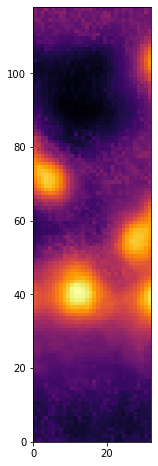

In [45]:
x_fake2=gen_output_slice_for_concatenate(input_data.to(device), gen, roll_increment=4, width=32)

color_scheme='inferno'
fig, ax = plt.subplots(1,1, figsize=(18,8))
ax.pcolormesh(x_fake[0,0,90,:,:].cpu(), cmap=color_scheme)
ax.set_aspect(1)